In [2]:
import pecos as pc
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Create the noise model
class DepolarGen(pc.error_gens.parent_class_error_gen.ParentErrorGen):
    
    two_qubit_gates = {'CNOT', 'CZ', 'SWAP', 'G', 'MS', 'SqrtXX', 'RXX'}
    one_qubit_gates = {'I', 'X', 'Y', 'Z', 'Q', 'Qd', 'R', 'Rd', 'S', 'Sd', 
                       'H', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H+z+x', 'H-z-x', 
                       'H+y-z', 'H-y-z', 'H-x+y', 'H-x-y', 'F1', 'F1d', 'F2', 
                       'F2d', 'F3', 'F3d', 'F4', 'F4d', 'RX', 'RY', 'RZ'}
    init_z = {'init |0>', 'init |1>'}
    init_xy = {'init |+>', 'init |->', 'init |+i>', 'init |-i>'}
    meas_z = {'measure Z'}
    meas_xy = {'measure X', 'measure Y'}
    error_one_paulis_collection = ['X','Y','Z']
    error_two_paulis_collection = [
            ('I', 'X'), ('I', 'Y'), ('I', 'Z'),
            ('X', 'I'), ('X', 'X'), ('X', 'Y'), ('X', 'Z'),
            ('Y', 'I'), ('Y', 'X'), ('Y', 'Y'), ('Y', 'Z'),
            ('Z', 'I'), ('Z', 'X'), ('Z', 'Y'), ('Z', 'Z')
    ]
    
    def start(self, circuit, error_params, state):
        super().start(circuit, error_params)
        
    def generate_tick_errors(self, tick_circ, time, **params):
        
        if type(time) == tuple: tick_index = time[-1]
        else: tick_index = time
        
        before = pc.circuits.QuantumCircuit() # faults before tick
        after  = pc.circuits.QuantumCircuit() # faults after tick
        
        q0 = lambda locs, fault, p: [{fault: {l}} for l in locs if np.random.random() <= p]
        q1 = lambda locs, faults, p: [{np.random.choice(faults): {l}} for l in locs if np.random.random() <= p]
        q2 = lambda locs, faults, p: [{f: {l}} for ltup in locs  if np.random.random() <= p for (l,f) in zip(ltup, faults[np.random.choice(len(faults))])]
        
        qc_append = lambda qc, circuit_setup: [qc.append(tick) for tick in circuit_setup]
        
        for sym, locs, _ in tick_circ.circuit.items(tick_index):
            if sym in self.init_z:
                qc_append(after, q0(locs, 'X', self.error_params['r']))
            elif sym in self.init_xy:
                qc_append(after, q0(locs, 'Z', self.error_params['r']))
            elif sym in self.meas_z:
                qc_append(before, q0(locs, 'X', self.error_params['q']))
            elif sym in self.meas_xy:
                qc_append(before, q0(locs, 'Z', self.error_params['q']))
            elif sym in self.one_qubit_gates:
                qc_append(after, q1(locs, self.error_one_paulis_collection, self.error_params['p1']))
            elif sym in self.two_qubit_gates:
                qc_append(after, q2(locs, self.error_two_paulis_collection, self.error_params['p2']))
            elif symbol == 'wait_initial' or symbol == 'wait_final':
                pass
            else:
                raise Exception("This error model doesn't handle gate: %s!" % symbol)
        self.error_circuits.add_circuits(time, before_faults=before, after_faults=after)
        return self.error_circuits

CPU times: user 10.8 s, sys: 11.7 ms, total: 10.8 s
Wall time: 10.8 s


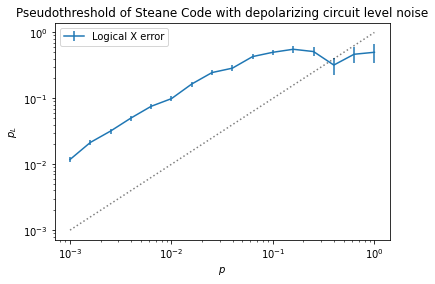

In [16]:
%%time

n_qbs = 10
plaquettes = [(3,4,5,6),(0,2,4,6),(1,2,5,6)] # correspond to stab set.
msmt_qbs = [7,8,9]
COR_TABLE = { 7: 3, 8: 0, 9: 1, 7+8: 4, 8+9: 2, 7+9: 5, 7+8+9: 6 }

# Generate circuits
def plaquette_qc(basis):
    qc = pc.circuits.QuantumCircuit()
    qc.append('init %s' % ('|0>' if basis == 'Z' else '|+>'), {7,8,9})
    for m_qb, plaquette in zip(msmt_qbs, plaquettes):
        for d_qb in plaquette:
            if basis == 'Z': qc.append('CNOT', {(d_qb, m_qb)})   # detect and correct X errors
            elif basis == 'X': qc.append('CNOT', {(m_qb, d_qb)}) # detect and correct Z errors
    qc.append('measure %s' % basis, {7,8,9}) # measure msmt qbs
    return qc

steane_x = plaquette_qc(basis='X')
steane_z = plaquette_qc(basis='Z')
circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))
# depolar = pc.error_gens.DepolarGen(model_level='circuit')

def MC(p, samples):
    logical_errs = 0
    e_params = {'r':p, 'q':p, 'p1':p, 'p2':p}
    for _ in range(samples):
        state = pc.simulators.SparseSim(n_qbs)

        # Measure measurement qubits
        x_msmt, _ = circ_runner.run(state, steane_x, error_gen=DepolarGen(), error_params=e_params)
        z_msmt, _ = circ_runner.run(state, steane_z, error_gen=DepolarGen(), error_params=e_params)  
        
        # equivalent.
        # x_msmt, _ = circ_runner.run(state, steane_x, error_gen=depolar, error_params={'p':p})
        # z_msmt, _ = circ_runner.run(state, steane_z, error_gen=depolar, error_params={'p':p}) 
        
        # Calculate syndromes, apply correction (if any)
        x_syn = sum(list(*x_msmt.values()))
        z_syn = sum(list(*z_msmt.values()))
        if x_syn: state.run_gate('Z', {COR_TABLE[x_syn]})
        if z_syn: state.run_gate('X', {COR_TABLE[z_syn]})
        
        # Measure Z
        msmt, _ = circ_runner.run(state, pc.circuits.QuantumCircuit([{'measure Z': {0,1,2,3,4,5,6}}]))
        parity = len(list(*msmt.values())) % 2
        logical_errs += parity
    return logical_errs

res = 16
n_samples = 10
pp_range = np.logspace(-3,0,res) # physical error rate range 1e-3..1
sample_range = np.int_(n_samples/pp_range)
x_fail_rate = np.empty_like(pp_range)

for i in range(res):
    x_fails = MC(pp_range[i], sample_range[i])
    x_fail_rate[i] = x_fails / sample_range[i]
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold of Steane Code with depolarizing circuit level noise')
plt.errorbar(pp_range, x_fail_rate, yerr=np.sqrt((x_fail_rate-x_fail_rate**2)/sample_range), label='Logical X error')
plt.plot(pp_range, pp_range, 'k:', alpha=0.5)
plt.legend()